## get-mean-variance-plots-imputed
3.6.23

This notebook plots the relationship between mean and variance for sets of technical replicate runs. The only difference between this notebook and the standard version, `get-mean-variance-plots.ipynb`, is that here we're generating plots post-imputation. The big question here is what impute method to use for this? I think NMF and missForest are obvious choice, because they seem to work the best. kNN would be a good choice as well. Maybe there's a version of this figure where we include multiple panels, so that we can show results from various impute methods? 

Has an `impute_method` parameter so that you can generate a new set of plots for each impute method. 

In [1]:
import pandas as pd
import numpy as np
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('../../../bin/')

# plotting templates
sns.set(context="talk", style="ticks") 
sns.set_palette("tab10")

#### Configs

In [2]:
# main 
stem = "../output/"

impute_method = "gsample" # "nmf", "mf", "gsample"
n_replicates = [3,5,6,10]
pxds = ["PXD016079", "PXD034525", "PXD014525", "PXD006109"]

# n_replicates = [3]
# pxds = ["PXD016079"]

#### Helper funcs

In [3]:
def get_mean_var_std(df, n_replicates):
    """ 
    For the intensity cols of a single MaxQuant dataframe, break down
    column-wise according to the number of replicates in the matrix, 
    then get means and variances for each peptide, for each replicate.
    Also get peptide standard deviations. 
        
    Assumes columns are in sorted order! as in, the replicate runs are
    next to one another. 
    
    Parameters
    ----------
    df: Matrix of intensity vals, for a single PRIDE experiment
    n_replicates: Number of replicates for each run within that PRIDE
                    experiment
    
    Returns
    -------
    all_means_flat: Flattened (1D) array of all peptide means
    all_vars_flat: Flattened (1D) array of all peptide variances
    all_stds_flat: Flattened (1D) array of all peptide standard deviations
    """
    
    cols = list(df.columns)
    r_split_cols = [cols[i:i+n_replicates] for i in range(0,len(cols), n_replicates)]

    all_means = []
    all_vars = []
    all_stds = []
    
    for i in df.index:
        peptide_means = []
        peptide_vars = []
        peptide_stds = []
    
        for j in range(0,len(r_split_cols)):
            rep_df = df[r_split_cols[j]]
            peptide_mean = np.nanmean(rep_df.iloc[i])
            peptide_var = np.nanvar(rep_df.iloc[i])
            peptide_std = np.nanstd(rep_df.iloc[i])
        
            peptide_means.append(peptide_mean)
            peptide_vars.append(peptide_var)
            peptide_stds.append(peptide_std)
            
        all_means.append(peptide_means)
        all_vars.append(peptide_vars)
        all_stds.append(peptide_stds)
        
    all_means_flat = np.array(all_means).flatten()
    all_vars_flat = np.array(all_vars).flatten()
    all_stds_flat = np.array(all_stds).flatten()
        
    return all_means_flat, all_vars_flat, all_stds_flat

#### The main loop
For each peptide quants dataset, collect means and variances across technical replicate runs.

In [4]:
aggregated = pd.DataFrame(columns=["means", "variances", "stds", "PXD"])

for pxd, n_rep in zip(pxds, n_replicates):
    print("working on: ", pxd)
    # read in, convert 0s to np.nans
    df = pd.read_csv(stem + pxd + "-" + impute_method + "-imputed.csv")
    df[df==0] = np.nan
    
    means, variances, stds = get_mean_var_std(df, n_rep)
    
    tmp = pd.DataFrame(columns=["means", "variances", "stds", "PXD"])
    tmp["means"] = means
    tmp["variances"] = variances
    tmp["stds"] = stds
    tmp["PXD"] = pxd
    
    aggregated = pd.concat([aggregated, tmp], ignore_index=False)
    
aggregated = aggregated.reindex()

# set zeros to np.nan....my guess is that a zero variance
#     or zero std value corresponds to a peptide that only 
#     had a quant value for a single replicate
aggregated[aggregated==0] = np.nan

working on:  PXD016079
working on:  PXD034525
working on:  PXD014525
working on:  PXD006109


#### Generate plot

In [5]:
# plt.figure(figsize=(6,6))
# sns.scatterplot(
#     data=aggregated, x="means", y="variances", hue="PXD", 
#     alpha=0.03, edgecolors="none")

# plt.minorticks_off()

# plt.xlabel("Mean")
# plt.ylabel("Variance")

# # log scale the axes? Note this is not the same as logging the data
# plt.xscale("log")
# plt.yscale("log")

# ax = plt.gca()

# # get the mins and maxes of the means and vars
# means_qmax = np.nanquantile(aggregated["means"], 0.999)
# means_qmin = np.nanquantile(aggregated["means"], 0.001)

# vars_qmax = np.nanquantile(aggregated["variances"], 0.999)
# vars_qmin = np.nanquantile(aggregated["variances"], 0.001)

# axes_max = np.max([means_qmax, vars_qmax])
# axes_min = np.min([means_qmin, vars_qmin])

# # this was hand tuned....probably not ideal
# axes_min = 1
# axes_max = axes_max + 1e12

# ax.plot([axes_min, axes_max], [axes_min, axes_max], color="black", zorder=0, alpha=0.7, label='y=x')
# ax.set_aspect('equal', 'box')

# ax.set_xlim(axes_min, axes_max)
# ax.set_ylim(axes_min, axes_max)

# plt.legend(
#     frameon=True, 
#     fancybox=False, 
#     loc="lower right", 
#     edgecolor="black",
#     handlelength=0.5,
#     borderaxespad=0,
#     fontsize="small",
# )

# plt.tight_layout()
# plt.show()

***

## The logged version 

#### The main loop 

In [6]:
aggregated_log = pd.DataFrame(columns=["means", "variances", "stds", "PXD"])

for pxd, n_rep in zip(pxds, n_replicates):
    print("working on: ", pxd)
    # read in, convert 0s to np.nans
    df = pd.read_csv(stem + pxd + "-" + impute_method + "-imputed.csv")
    df[df==0] = np.nan
    
    # log the peptide quants
    df = np.log(df)
    
    means, variances, stds = get_mean_var_std(df, n_rep)
    
    tmp = pd.DataFrame(columns=["means", "variances", "stds", "PXD"])
    tmp["means"] = means
    tmp["variances"] = variances
    tmp["stds"] = stds
    tmp["PXD"] = pxd
    
    aggregated_log = pd.concat([aggregated_log, tmp], ignore_index=False)
    
aggregated_log = aggregated_log.reindex()

# set zeros to np.nan....my guess is that a zero variance
#     or zero std value corresponds to a peptide that only 
#     had a quant value for a single replicate
aggregated_log[aggregated_log==0] = np.nan

working on:  PXD016079
working on:  PXD034525
working on:  PXD014525
working on:  PXD006109


#### Plot the logged version 

In [7]:
# plt.figure(figsize=(6,6))
# sns.scatterplot(
#     data=aggregated_log, x="means", y="variances", hue="PXD", 
#     alpha=0.05, edgecolors="none")

# plt.minorticks_off()

# plt.xlabel("Mean")
# plt.ylabel("Variance")

# ax = plt.gca()

# lims = [
#         np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
#         np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
#         ]

# ax.plot(lims, lims, color="black", zorder=0, alpha=0.7, label='y=x')
# ax.set_aspect('equal', 'box')

# plt.legend(
#     frameon=True, 
#     fancybox=False, 
#     loc="lower right", 
#     edgecolor="black",
#     handlelength=0.5,
#     borderaxespad=0,
#     fontsize="small",
# )

# plt.tight_layout()
# plt.show()

***

## Side-by-side plots

#### For the non-logged dataset, get the maxes and mins

In [8]:
# get the mins and maxes of the means and vars
means_qmax = np.nanquantile(aggregated["means"], 0.999)
means_qmin = np.nanquantile(aggregated["means"], 0.001)

vars_qmax = np.nanquantile(aggregated["variances"], 0.999)
vars_qmin = np.nanquantile(aggregated["variances"], 0.001)

axes_max = np.max([means_qmax, vars_qmax])
axes_min = np.min([means_qmin, vars_qmin])

# this was hand tuned....probably not ideal
axes_min = 1
axes_max = axes_max + 1e22

# should probably just set these by hand, 
    # so that the various impute methods will be on the same axes
axes_min = 1
axes_max = 1.0021720415076188e+22

#### Plot, side-by-side

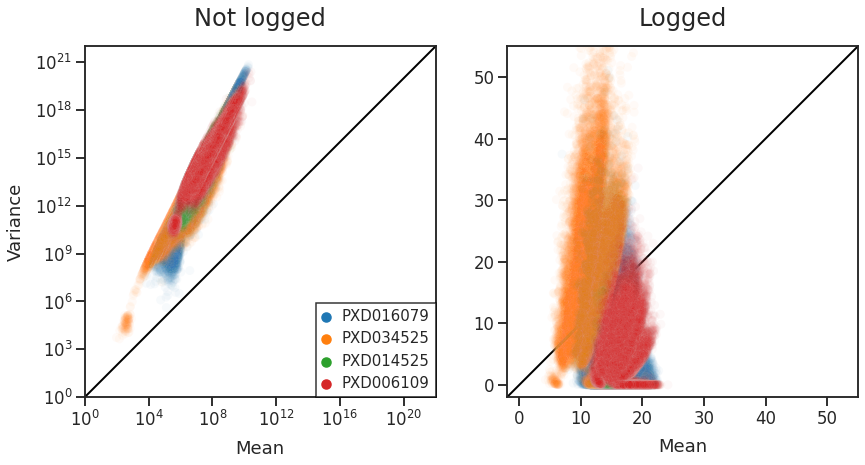

In [16]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,6)) #sharey=False, sharex=False
fig.tight_layout()

sns.scatterplot(
    data=aggregated, x="means", y="variances", hue="PXD", 
    alpha=0.03, edgecolors="none", ax=axes[0])
axes[0].minorticks_off()
axes[0].set_xlabel("Mean", labelpad=10)
axes[0].set_ylabel("Variance", labelpad=10)
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_title("Not logged", size=24, pad=20)
axes[0].get_legend().remove()

axes[0].plot(
    [axes_min, axes_max], [axes_min, axes_max], 
    color="black", zorder=0, alpha=1, linewidth=2)
axes[0].set_aspect('equal', 'box')

# set axis limits for the non-logged plot
axes[0].set_xlim(axes_min, axes_max)
axes[0].set_ylim(axes_min, axes_max)

sns.scatterplot(
    data=aggregated_log, x="means", y="variances", hue="PXD", 
    alpha=0.03, edgecolors="none", ax=axes[1])
axes[1].minorticks_off()
axes[1].set_xlabel("Mean", labelpad=10)
axes[1].set_ylabel("")
axes[1].set_title("Logged", size=24, pad=20)
#axes[1].get_legend().remove()

# establish the axis limits for the logged plot
lims = [
        np.min([axes[1].get_xlim(), axes[1].get_ylim()]),  # min of both axes
        np.max([axes[1].get_xlim(), axes[1].get_ylim()]),  # max of both axes
        ]

# adjusting the axis limits by hand
lims[0] = -2 # -3 for all three
lims[1] = 55 # 26 for missForest, 45 for NMF

axes[1].plot(lims, lims, color="black", zorder=0, alpha=1, linewidth=2)
axes[1].set_aspect('equal', 'box')

# set axis limits for the logged plot
axes[1].set_xlim(lims)
axes[1].set_ylim(lims)

axes[1].get_legend().remove()
axes[0].legend(
        frameon=True, 
        fancybox=False, 
        loc="lower right", 
        edgecolor="black",
        handlelength=0.5,
        borderaxespad=0,
        fontsize="small",
)

# plt.savefig(
#     "../figures/distributions-fig-gsample-impute-sidexside.png", dpi=250, bbox_inches="tight")

***

## Individual plots, again
For the sake of generating a composite figure with Inkscape,
it might be better to save these as separate plot objects/pngs. 
Should try to keep all of the axis limits the same, to allow for easy comparison between NMF imputed, missForest imputed, kNN imputed, etc. 

#### The standard case

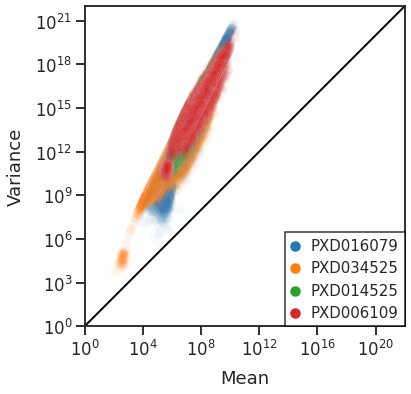

In [10]:
plt.figure(figsize=(6,6))

sns.scatterplot(
    data=aggregated, x="means", y="variances", hue="PXD", 
    alpha=0.03, edgecolors="none")

plt.minorticks_off()
plt.xlabel("Mean", labelpad=10)
plt.ylabel("Variance", labelpad=10)
plt.xscale("log")
plt.yscale("log")

ax = plt.gca() 
ax.plot(
    [axes_min, axes_max], [axes_min, axes_max], 
    color="black", zorder=0, alpha=1, linewidth=2)
ax.set_aspect('equal', 'box')

# set axis limits
ax.set_xlim(axes_min, axes_max)
ax.set_ylim(axes_min, axes_max)

plt.legend(
        frameon=True, 
        fancybox=False, 
        loc="lower right", 
        edgecolor="black",
        handlelength=0.5,
        borderaxespad=0,
        fontsize="small",
)

plt.tight_layout()
plt.savefig(
    "../figures/distributions-nonlogged-nmf-impute-v2.png", dpi=250, bbox_inches="tight")

#### The logged case

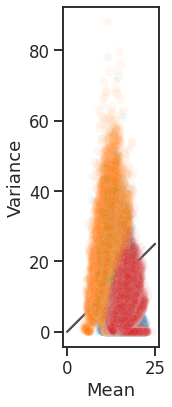

In [11]:
plt.figure(figsize=(6,6))
sns.scatterplot(
    data=aggregated_log, x="means", y="variances", hue="PXD", 
    alpha=0.05, edgecolors="none")

plt.minorticks_off()

plt.xlabel("Mean")
plt.ylabel("Variance")

ax = plt.gca()

# establish the axis limits
lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
        ]

# adjusting the axis limits by hand
lims[0] = 0
lims[1] = 25

# lims = [
#         np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
#         np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
#         ]

ax.plot(lims, lims, color="black", zorder=0, alpha=0.7, label='y=x')
ax.set_aspect('equal', 'box')
ax.get_legend().remove()

# plt.legend(
#     frameon=True, 
#     fancybox=False, 
#     loc="lower right", 
#     edgecolor="black",
#     handlelength=0.5,
#     borderaxespad=0,
#     fontsize="small",
# )

plt.tight_layout()
plt.savefig(
    "../figures/distributions-logged-nmf-impute-v2.png", dpi=250, bbox_inches="tight")